In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

# olist_orders_dataset.csv —  таблица заказов
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

# — Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

# Уникальные статусы заказов в таблице olist_orders_dataset:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [3]:
# 1. Сколько у нас пользователей, которые совершили покупку только один раз?
# Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. 
# Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [4]:
# Рассмотрим таблицу с заказами olist_orders_dataset.csv
df_orders = pd.read_csv('./olist_orders_dataset.csv')
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# Покупкой будем считать факт оплаты товара или нескольких товаров в заказе.
# Не важно, что потом произошло - отменили заказ, отсутвует товар или еще что, 
# но заказ был изначально оплачен, т.е. совершенна покупка.

# Логично было бы предположить, что должен быть статус "заказ оплачен", но в данной таблице такого вообще нет.
# Статус "выставлен счет" еще не означает и не подтверждает факт оплаты, 
# т.к. покупатель может впоследствии отказаться и не оплатить заказ.
# Статус "в процесс сборки" также не говорит нам о том, что заказ оплачен, 
# возможно его собирают по договоренности с менеджером об постоплате, отсрочке и т.п.
# Как и остальные подобные статусы - отгружен, доставлен, недоступен, отменен.

# Поэтому за покупку принимаем заполненную колонку order_approved_at —  время подтверждения оплаты заказа, 
# т.е. факт того, что продавец увидел оплату от покупателя.

In [6]:
df_orders.isnull().sum() 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
# Рассмотрим таблицу с пользователями olist_customers_dataset.csv
df_customers = pd.read_csv('./olist_customers_dataset.csv')
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# Что из них считать уникальным пользователем ?

In [9]:
df_customers.customer_id.nunique() # кол-во уникальных значений

99441

In [10]:
df_orders.order_id.nunique() # кол-во уникальных значений

99441

In [11]:
df_customers.customer_unique_id.nunique() # кол-во уникальных значений

96096

In [12]:
# customer_id - как и предполагалось, соответствует оформлению одного уникального заказа (пользователеь мог оформлять несколько разных заказов)
# customer_unique_id - является уникальным пользователем

In [13]:
# объединим таблицы с заказами и пользователями и оставим только интересующие нас столбцы
merged_table = pd.merge(df_customers[['customer_unique_id','customer_id']], \
                        df_orders[['order_approved_at','customer_id']], \
                        on='customer_id') 
merged_table.head()

,customer_unique_id,customer_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 17:29:19
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 10:10:09


In [14]:
merged_table.isnull().sum() 
# ищем пропущенные значения и видим, что 160 заказов не были еще оплачены, т.е. не была совершена покупка

customer_unique_id      0
customer_id             0
order_approved_at     160
dtype: int64

In [15]:
merged_table = merged_table.dropna() # удаляем строки с пропущенными значениями
merged_table.shape

(99281, 3)

In [16]:
# сгруппируем по уникальным пользователям и посчитаем кол-во покупок для каждого
merged_table.groupby('customer_unique_id', as_index=False)\
            .agg({'order_approved_at':'count'})\
            .sort_values('order_approved_at', ascending = False)\
            .rename(columns={'order_approved_at':'check'})

,customer_unique_id,check
52925,8d50f5eadf50201ccdcedfb9e2ac8455,17
23450,3e43e6105506432c953e165fb2acf44c,9
10344,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37764,6469f99c1f9dfae7733b25662e7f1782,7
76005,ca77025e7201e3b30c44b472ff346268,7
...,...,...
32466,56546b71f8bf254f860014fae431af6d,1
32464,565427a96f0865bacef2a6b400197b46,1
32463,565283fe12fa1a894ef451c4bfb391ed,1
32462,5650e95cbd234d30d80befa7c4ab1618,1


In [17]:
merged_table.groupby('customer_unique_id', as_index=False)\
            .agg({'order_approved_at':'count'})\
            .query('order_approved_at == 1')\
            .order_approved_at.count()
# посчитали пользователей, совершивших покупку только один раз

93049

In [18]:
##############################################################################################################################

In [19]:
# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

In [20]:
# Что является не доставленным заказом? Какие будем считать?

# Это все заказы без статуса delivered (доставлен пользователю), что логично, 
# и без статуса created (просто созданные заказы, не подтвержденные, соответсвенно еще нет оформленного заказа)

# По всем остальным статусам будем считать, что они не доставлены, 
# т.к. даже если заказ еще не был оплачен, 
# то можно предполагать, что доставка все равно должна быть.
# (как пример - Вайлдбериз, где заказы на пункт выдачи доставляются без предварительной оплаты)

# в подтвержение посмотрим на доставленные заказы
df_orders.query('order_status == "delivered"' ).isnull().sum()
# и видим, что на самом деле было доставлено 14 заказов, которые еще не были оплачены

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [21]:
df_no_delivered = df_orders.query('order_status != ("delivered", "created")') #оставим только недоставленные заказы
df_no_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [22]:
# Для расчет месячного интервала будем использовать столбец order_purchase_timestamp —  время создания заказа

In [23]:
df_no_delivered["order_purchase_timestamp"] = pd.to_datetime(df_no_delivered['order_purchase_timestamp'])
# переведем столбец с датами  к типу данных дата

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_no_delivered["order_purchase_timestamp"] = df_no_delivered['order_purchase_timestamp'].dt.strftime('%Y-%m')
# оставим только год и месяц

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_no_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [26]:
df_no_delivered.shape

(2958, 8)

In [27]:
df_no_delivered['order_status'] = df_no_delivered['order_status'].astype('category')
# делаем тип данных категории, чтобы не пропали отсутвующие статусы по месяцам
df_no_delivered.dtypes

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


order_id                           object
customer_id                        object
order_status                     category
order_purchase_timestamp           object
order_approved_at                  object
order_delivered_carrier_date       object
order_delivered_customer_date      object
order_estimated_delivery_date      object
dtype: object

In [28]:
# сгруппируем данные по месяцам и статусам и посчитаем кол-во недоставленных заказов для каждого
df_no_delivered_2 = df_no_delivered.groupby(['order_purchase_timestamp', 'order_status'])\
                                   .agg({'order_id':'count'})
df_no_delivered_2

order_id
order_purchase_timestamp order_status          
2016-09                  approved             0
                         canceled             2
                         invoiced             0
                         processing           0
                         shipped              1
...                                         ...
2018-10                  canceled             4
                         invoiced             0
                         processing           0
                         shipped              0
                         unavailable          0

[144 rows x 1 columns]

In [29]:
# теперь еще раз сгрупируем по статусам и посчитаем среднее число для каждого статуса в месяц
df_no_delivered_2 = df_no_delivered.groupby(['order_purchase_timestamp', 'order_status'])\
                                   .agg({'order_id':'count'}) \
                                   .groupby('order_status')\
                                   .agg({'order_id':'mean'})\
                                   .rename(columns={'order_id':'order_by_month_no_delivery'})\
                                   .reset_index()
df_no_delivered_2

,order_status,order_by_month_no_delivery
0,approved,0.083333
1,canceled,26.041667
2,invoiced,13.083333
3,processing,12.541667
4,shipped,46.125000
5,unavailable,25.375000


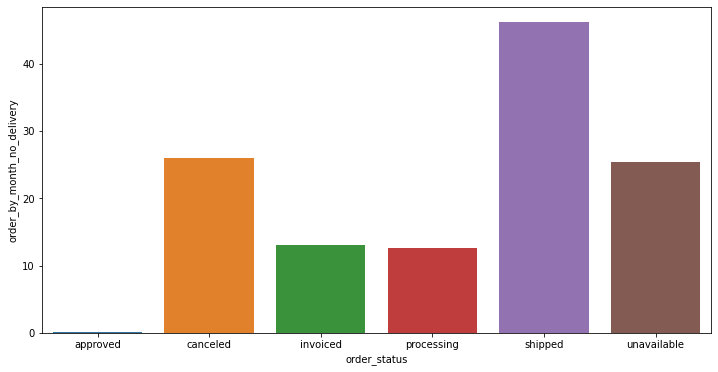

In [30]:
# Сколько заказов в месяц в среднем не доставляется по разным причинам
plt.subplots(figsize=(12, 6))
sns.barplot(x="order_status", y="order_by_month_no_delivery", data=df_no_delivered_2)
# approved —  подтверждён (заказ только получен)
# invoiced —  выставлен счёт (заказ в процессе оформления)
# processing —  в процессе сборки заказа (еще не отгружен)
# shipped —  отгружен со склада (заказ еще в пути)
# unavailable —  недоступен (нет на складе)
# canceled —  отменён

In [31]:
#############################################################################################################################

In [32]:
# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [33]:
# Вспоминаем, что за покупку принимаем колонку # order_approved_at —  время подтверждения оплаты заказа, 
# из этой даты и будем выстаскивать день недели

In [34]:
df_orders["order_approved_at"] = pd.to_datetime(df_orders['order_approved_at'])
# переведем столбец с датами  к типу данных дата

In [35]:
df_orders['purchase_day'] = df_orders['order_approved_at'].dt.day_name()
#вытащим из даты день недели
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday


In [36]:
# подгрузим таблицу с товарами
df_items = pd.read_csv('./olist_order_items_dataset.csv')
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [37]:
# объединим таблицы и оставим только интересующие нас столбцы
df_item_by_day = pd.merge(df_orders[['order_id','purchase_day']],\
                          df_items[['order_id','product_id']],\
                          on='order_id') # объединяем таблицы
df_item_by_day.head()

,order_id,purchase_day,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,Monday,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,Thursday,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,65266b2da20d04dbe00c5c2d3bb7859e


In [38]:
df_item_by_day.isnull().sum() #проверим неоплаченные товары

order_id         0
purchase_day    15
product_id       0
dtype: int64

In [39]:
df_item_by_day = df_item_by_day.dropna() #удалим строки с неоплаченными товарами, т.к. это еще не покупка

In [40]:
df_item_by_day.head()

,order_id,purchase_day,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,Monday,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,Thursday,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,65266b2da20d04dbe00c5c2d3bb7859e


In [41]:
# группируем по товару и дню покупки, считаем для них число покупок, 
# сортируем в порядке убывания кол-ва и оставляем только первое вхождение(т.е. самое большое число)

df_item_by_day.groupby(['product_id', 'purchase_day'], as_index=False)\
              .agg({'order_id' : 'count'})\
              .sort_values('order_id', ascending = False) \
              .groupby('product_id', as_index=False)\
              .first()\
              .sort_values('order_id', ascending = False)\
              .rename(columns={'order_id':'purchase_per_day'})

,product_id,purchase_day,purchase_per_day
22110,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
10865,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
8612,422879e10f46682990de24d770e7f83d,Tuesday,89
19740,99a4788cb24856965c36a24e339b6058,Tuesday,82
7078,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
12728,62874f62bbdeec35f7cd827b1716c47e,Wednesday,1
12727,628677036f276f6c0792cded8e9211ee,Thursday,1
12726,6281a79f478d260d81da138f7e03c0bb,Friday,1
12725,627dce1ab24323cb7ac147cad5ac0b8c,Friday,1


In [42]:
##############################################################################################################################

In [43]:
# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
# Не стоит забывать, что внутри месяца может быть не целое количество недель. 
# Например, в ноябре 2021 года 4,28 недели. 
# И внутри метрики это нужно учесть. 

In [44]:
# Вспоминаем, что за покупку принимаем колонку # order_approved_at —  время подтверждения оплаты заказа

In [45]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday


In [46]:
df_orders.dtypes # проверим типы данных

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
purchase_day                             object
dtype: object

In [47]:
# создаем колонку с месяцем покупки и колонку с кол-вом дней в месяце
df_orders['purchase_month'] = df_orders.order_approved_at.dt.strftime('%Y-%m')
df_orders['days_in_month'] = df_orders.order_approved_at.dt.days_in_month

In [48]:
df_orders.dtypes 

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
purchase_day                             object
purchase_month                           object
days_in_month                           float64
dtype: object

In [49]:
# объединяем таблицы
purchase_by_week = pd.merge(df_orders[['customer_id', 'order_id','purchase_month', 'days_in_month']], \
                            df_customers[['customer_id','customer_unique_id']],\
                            on='customer_id')
purchase_by_week.head()

,customer_id,order_id,purchase_month,days_in_month,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10,31.0,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07,31.0,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08,31.0,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,30.0,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02,28.0,72632f0f9dd73dfee390c9b22eb56dd6


In [50]:
# группируем по уникальным пользователям и месяцу покупки, считаем кол-во покупок в месяц
purchase_by_week = purchase_by_week.groupby(['customer_unique_id','purchase_month','days_in_month'], as_index=False)\
                         .agg({'order_id':'count'})\
                         .rename(columns={'order_id' : 'purchase_by_month'})
purchase_by_week

,customer_unique_id,purchase_month,days_in_month,purchase_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,31.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,31.0,1
2,0000f46a3911fa3c0805444483337064,2017-03,31.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,31.0,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,30.0,1
...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,30.0,1
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,31.0,1
97909,ffff371b4d645b6ecea244b27531430a,2017-02,28.0,1
97910,ffff5962728ec6157033ef9805bacc48,2018-05,31.0,1


In [51]:
# делаем стобец с кол-вом покупок в неделю, учитывая не целое кол-во недель в месяцах
purchase_by_week['purchase_by_week'] =  purchase_by_week.purchase_by_month / \
                                       (purchase_by_week.days_in_month / 7)
purchase_by_week

,customer_unique_id,purchase_month,days_in_month,purchase_by_month,purchase_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,31.0,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,31.0,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,31.0,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,31.0,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,30.0,1,0.233333
...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,30.0,1,0.233333
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,31.0,1,0.225806
97909,ffff371b4d645b6ecea244b27531430a,2017-02,28.0,1,0.250000
97910,ffff5962728ec6157033ef9805bacc48,2018-05,31.0,1,0.225806


In [52]:
############################################################################################################################

In [53]:
# 5.1. Выполните когортный анализ пользователей.
# 5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. 
    #Описание подхода можно найти тут https://vc.ru/productstar/134090-chto-takoe-kogortnyy-analiz
    #Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python, раздел “Стильный урок”, степ 5. 
    #https://lab.karpov.courses/learning/318/module/3099/lesson/27529/77876/364090/

In [54]:
# Перед проведением когортного анализа определяют четыре параметра:

# Признак формирования когорты — действие, которое объединяет людей в группу:
# первый визит, покупка, установка, регистрация и т.п.
# У нас это будет покупка

# Размер когорты — временной интервал: день, неделя, месяц.
# У нас это будет месяц

# Отчетный период — время исследования поведения групп.
# У нас это год - с января по декабрь

# Анализируемый ключевой показатель: ROI, Retention Rate, LTV и т.д.
# У нас это Retention Rate - т.е. когда пользователь совершил вторую покупку после первой


In [55]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day,purchase_month,days_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday,2017-10,31.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Thursday,2018-07,31.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday,2018-08,31.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday,2017-11,30.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday,2018-02,28.0


In [56]:
retention_table = pd.merge(df_customers[['customer_unique_id','customer_id']],\
                           df_orders[['purchase_month','customer_id']],\
                           on='customer_id') # объединяем таблицы
retention_table.head()

,customer_unique_id,customer_id,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07


In [57]:
retention_table.isnull().sum() # есть ли строки с пропущенными занчениями

customer_unique_id      0
customer_id             0
purchase_month        160
dtype: int64

In [58]:
retention_table = retention_table.dropna() # удаляем строки с неоплаченными покупками
retention_table.sort_values('purchase_month')

,customer_unique_id,customer_id,purchase_month
21125,830d5b7aaa3b6f1e9ad63703bec97d23,86dc2ffce2dfff336de2f386a786e574,2016-09
36410,381411bd0b3e1aff0b23bfed26d000af,cabe1ec4e4c40db3c14ab19cc09bbd9a,2016-10
25140,33fbcb38d3009eddfe53b3063c642959,ad29d9bb283d87e61e190d40bc7bc15b,2016-10
76343,9eecbc54a48d750ac6762ab31477fb9f,b692755548475c6db9d19858c5da06f1,2016-10
74649,84717d840af87a7fa12a66a0933ede2a,e9c6723e04c4e53e7e9c3afe383f3866,2016-10
...,...,...,...
76338,62e0e75323778a07135f9a25a3831cf2,7f0b0af2dbdab9d01ccd55d267db69f7,2018-08
76345,c6e7ba32d3400f590ab17def32f625a6,237ef1499471be17e7f082cbbc911c90,2018-08
76289,c55a587f3f473189e4dcb9c9fea74fea,696701728a4e18b1373bce09400fa4b5,2018-08
71139,2828ec50f07f48714d037a800fa806a5,1bc8d7df252ed7ef6595a0323345ddac,2018-08


In [59]:
# У нас есть данные за 2 года, но полный (с января по декабрь) только один - 2017
# Кроме того, чтобы получить данные retention на 3-1 месяц для пользователей декабря 2017 года, 
# нужно добавить еще три месяца из 2018 года
retention_table = retention_table.query('purchase_month > "2016-12" and purchase_month < "2018-04"')
retention_table.head()

,customer_unique_id,customer_id,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03
5,4c93744516667ad3b8f1fb645a3116a4,879864dab9bc3047522c92c82e1212b8,2017-09
6,addec96d2e059c80c30fe6871d30d177,fd826e7cf63160e536e0908c76c3f441,2018-02


In [60]:
retention_table.shape

(66154, 3)

In [61]:
# найдем для каждого пользователя, когда у него была первая покупка
# сгруппируем по пользователям и выберем минимальное значение месяца
first_purchase = retention_table.groupby('customer_unique_id', as_index=False)\
                              .agg({'purchase_month': 'min'})\
                              .rename(columns={'purchase_month': 'first_purchase'})
first_purchase.head()

,customer_unique_id,first_purchase
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,00053a61a98854899e70ed204dd4bafe,2018-02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03


In [62]:
# объединим получившиеся данные 
retention_table = pd.merge(retention_table, first_purchase, how='left', on=['customer_unique_id'])
retention_table

,customer_unique_id,customer_id,purchase_month,first_purchase
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01,2018-01
2,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03,2018-03
3,4c93744516667ad3b8f1fb645a3116a4,879864dab9bc3047522c92c82e1212b8,2017-09,2017-09
4,addec96d2e059c80c30fe6871d30d177,fd826e7cf63160e536e0908c76c3f441,2018-02,2018-02
...,...,...,...,...
66149,d111b06b6f3a2add0d2241325f65b5ca,f255d679c7c86c24ef4861320d5b7675,2018-03,2018-03
66150,e7f8760e2bbd2f1986bebd99596c088e,14308d2303a3e2bdf4939b86c46d2679,2017-03,2017-03
66151,4b5820135d360a45552b5163835b1d89,7fe2e80252a9ea476f950ae8f85b0f8f,2017-12,2017-12
66152,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,2017-11,2017-11


In [63]:
# группируем по месяцу первого заказа и месяцам отчетного периода, 
# считаем число уникальных пользователей ( по одному заказу от каждого пользователя в месяц)
# т.е. смотрим  для каждого месяца первого заказа в какие месяцы пользователи делали еще покупки и сколько их было
retention_table = retention_table.groupby(['first_purchase','purchase_month'],  as_index=False)\
                                   .agg({'customer_unique_id':'nunique'})
retention_table

,first_purchase,purchase_month,customer_unique_id
0,2017-01,2017-01,727
1,2017-01,2017-02,4
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
114,2018-01,2018-02,25
115,2018-01,2018-03,28
116,2018-02,2018-02,6429
117,2018-02,2018-03,23


In [64]:
retention_table.dtypes # посмотрим наши типы данных

first_purchase        object
purchase_month        object
customer_unique_id     int64
dtype: object

In [65]:
# посчитаем для каждого строки период когорты - разницы между месяцами и первой покупкой
# (учитываем еще разницу в год)
retention_table['cogort_period'] = (pd.to_datetime(retention_table['purchase_month'])).dt.month -\
                                    (pd.to_datetime(retention_table['first_purchase'])).dt.month +\
                                    (\
                                    (pd.to_datetime(retention_table['purchase_month'])).dt.year -\
                                    (pd.to_datetime(retention_table['first_purchase'])).dt.year)*12
retention_table

,first_purchase,purchase_month,customer_unique_id,cogort_period
0,2017-01,2017-01,727,0
1,2017-01,2017-02,4,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
114,2018-01,2018-02,25,1
115,2018-01,2018-03,28,2
116,2018-02,2018-02,6429,0
117,2018-02,2018-03,23,1


In [66]:
retention_table.dtypes

first_purchase        object
purchase_month        object
customer_unique_id     int64
cogort_period          int64
dtype: object

In [67]:
# перевернем нашу таблицу
pivot_retention_table = retention_table.pivot(index='first_purchase', columns='cogort_period', values='customer_unique_id')\
                             .query('first_purchase <"2018-01"') # оставим строки только за 2017 год как нас просили
pivot_retention_table

cogort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,,
2017-01,727.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,2.0,2.0,6.0,3.0,1.0
2017-02,1736.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0,3.0,NaN
2017-03,2643.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,4.0,6.0,NaN,NaN
2017-04,2324.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,NaN,NaN,NaN
2017-05,3592.0,19.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,10.0,NaN,NaN,NaN,NaN
2017-06,3148.0,15.0,11.0,13.0,8.0,11.0,12.0,7.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3844.0,20.0,13.0,8.0,13.0,7.0,12.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4204.0,28.0,15.0,11.0,16.0,22.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4149.0,27.0,20.0,14.0,18.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# делим все столбцы на первый, чтобы почитать процент
pivot_retention_table = pivot_retention_table.div(pivot_retention_table[pivot_retention_table.columns[0]], axis = 0) 
pivot_retention_table

cogort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,,
2017-01,1.0,0.005502,0.002751,0.001376,0.004127,0.001376,0.005502,0.001376,0.001376,NaN,0.002751,0.002751,0.008253,0.004127,0.001376
2017-02,1.0,0.002304,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152,0.002880,0.001728,0.001728,NaN
2017-03,1.0,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,0.003784,0.001513,0.002270,NaN,NaN
2017-04,1.0,0.006024,0.002151,0.001721,0.003012,0.002582,0.003442,0.002582,0.003442,0.001721,0.002151,0.000861,NaN,NaN,NaN
2017-05,1.0,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,0.002506,0.003062,0.002784,NaN,NaN,NaN,NaN
2017-06,1.0,0.004765,0.003494,0.004130,0.002541,0.003494,0.003812,0.002224,0.001271,0.002224,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005203,0.003382,0.002081,0.003382,0.001821,0.003122,0.001041,0.001821,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006660,0.003568,0.002617,0.003806,0.005233,0.002617,0.002617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006508,0.004820,0.003374,0.004338,0.002651,0.002169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Красиво оформляем
ur_style = (pivot_retention_table
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='YlGn')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

cogort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_purchase,,,,,,,,,,,,,,,
2017-01,100.00%,0.55%,0.28%,0.14%,0.41%,0.14%,0.55%,0.14%,0.14%,,0.28%,0.28%,0.83%,0.41%,0.14%
2017-02,100.00%,0.23%,0.23%,0.17%,0.40%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,0.29%,0.17%,0.17%,
2017-03,100.00%,0.49%,0.34%,0.34%,0.34%,0.15%,0.15%,0.30%,0.30%,0.11%,0.38%,0.15%,0.23%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.26%,0.34%,0.17%,0.22%,0.09%,,,
2017-05,100.00%,0.53%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.28%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.35%,0.38%,0.22%,0.13%,0.22%,,,,,
2017-07,100.00%,0.52%,0.34%,0.21%,0.34%,0.18%,0.31%,0.10%,0.18%,,,,,,
2017-08,100.00%,0.67%,0.36%,0.26%,0.38%,0.52%,0.26%,0.26%,,,,,,,
2017-09,100.00%,0.65%,0.48%,0.34%,0.43%,0.27%,0.22%,,,,,,,,


In [70]:
# Когорта с самым высоким возвратом на 3-й месяц
pivot_retention_table.iloc[:,3].idxmax()

'2017-06'

In [71]:
#############################################################################################################################

In [72]:
# 6. 
# Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
# Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
# В кластеризации можешь выбрать следующие метрики: 
#     R - время от последней покупки пользователя до текущей даты, 
#     F - суммарное количество покупок у пользователя за всё время, 
#     M - сумма покупок за всё время. 
#     Подробно опиши, как ты создавал кластеры. 
# Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 
# Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик 
# recency от 130 до 500 дней, 
# frequency от 2 до 5 заказов в неделю, 
# monetary от 1780 до 3560 рублей в неделю. 
# Описание подхода можно найти https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [73]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [74]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day,purchase_month,days_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday,2017-10,31.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Thursday,2018-07,31.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday,2018-08,31.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday,2017-11,30.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday,2018-02,28.0


In [75]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
purchase_day                             object
purchase_month                           object
days_in_month                           float64
dtype: object

In [76]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [77]:
# объединяем таблицы
all_table = pd.merge(df_customers[['customer_unique_id','customer_id']],\
                        df_orders[['order_id','customer_id','order_approved_at']], on='customer_id') \
                        .drop('customer_id', axis=1)
all_table

,customer_unique_id,order_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09
...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 16:08:45
99437,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:35:12
99438,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:30:03
99439,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:31:20


In [78]:
# объединяем таблицы
merged_all_table = pd.merge(all_table, df_items[['price', 'order_id']], on='order_id') 
merged_all_table

,customer_unique_id,order_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00
...,...,...,...,...
112645,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 16:08:45,74.90
112646,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:35:12,114.90
112647,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:30:03,37.00
112648,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:31:20,689.00


In [79]:
merged_all_table.isnull().sum() # проверим пустые строки

customer_unique_id     0
order_id               0
order_approved_at     15
price                  0
dtype: int64

In [80]:
merged_all_table = merged_all_table.dropna() # удалим пустые строки

In [81]:
# Вспоминаем, что за покупку принимаем колонку  order_approved_at —  время подтверждения оплаты заказа

In [82]:
merged_all_table.order_approved_at.sort_values() 

24003   2016-09-15 12:16:38
24002   2016-09-15 12:16:38
24001   2016-09-15 12:16:38
19889   2016-10-04 09:43:32
67605   2016-10-04 10:18:57
                ...        
95826   2018-08-29 14:31:07
95825   2018-08-29 14:31:07
56513   2018-08-29 15:05:22
76157   2018-08-29 15:10:26
75052   2018-09-03 17:40:06
Name: order_approved_at, Length: 112635, dtype: datetime64[ns]

In [83]:
# Как правило, для RFM анализа используются данные за последний год 
# У нас старые данные (за 2016-2018 года), поэтому возьмем для анализа период в год от последнего даты
RFM_last_day = merged_all_table.order_approved_at.max() + timedelta(days=1) # добавим один день к последней дате
RFM_last_day

Timestamp('2018-09-04 17:40:06')

In [84]:
RFM_first_day = RFM_last_day - relativedelta(years=1) # посчитаем первую дату для анализа
RFM_first_day

Timestamp('2017-09-04 17:40:06')

In [85]:
# оставляем данные в нашей таблице только за нужный нам период за 1 год
merged_all_table = merged_all_table.query('order_approved_at > @RFM_first_day') 
merged_all_table

,customer_unique_id,order_id,order_approved_at,price
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,259.90
...,...,...,...,...
112645,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 16:08:45,74.90
112646,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:35:12,114.90
112647,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:30:03,37.00
112648,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:31:20,689.00


In [86]:
# frequency - суммарное количество покупок у пользователя за всё время
# группируем по уникальынм пользователям
# считаем число уникальных заказов (т.к. в одном заказе может быть несколько покупок, то строки с заказами могут дублироваться)
frequency = merged_all_table.groupby('customer_unique_id', as_index=False)\
                            .order_id.nunique()\
                            .rename(columns={'order_id':'frequency'})
frequency

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f6ccb0745a6a4b88665a16c9f078,1
3,0004aac84e0df4da2b147fca70cf8255,1
4,0004bd2a26a76fe21f786e4fbd80607f,1
...,...,...
73263,fffb09418989a0dbff854a28163e47c6,1
73264,fffbf87b7a1a6fa8b03f081c5f51a201,1
73265,fffcc512b7dfecaffd80f13614af1d16,1
73266,fffea47cd6d3cc0a88bd621562a9d061,1


In [87]:
df_items.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')
# посмотрим как выглядит заказ внутри
# одна строка - один продукт, делаем вывод, что для получения всей суммы одного заказа достаточно сложить суммы внутри заказа

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [88]:
# monetary - сумма покупок за всё время.
# группируем по уникальным пользователями и суммируме все цены
monetary = merged_all_table.groupby('customer_unique_id', as_index=False)\
                           .price.sum()\
                           .rename(columns={'price':'monetary'})
monetary

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,25.99
3,0004aac84e0df4da2b147fca70cf8255,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,154.00
...,...,...
73263,fffb09418989a0dbff854a28163e47c6,58.00
73264,fffbf87b7a1a6fa8b03f081c5f51a201,149.00
73265,fffcc512b7dfecaffd80f13614af1d16,688.00
73266,fffea47cd6d3cc0a88bd621562a9d061,64.89


In [89]:
# recency - время от последней покупки пользователя до текущей даты
# сгрупиируме общую таблицу по пользователям и оставим последнюю строчку в колонке с датой покупки
recency_table = merged_all_table.groupby('customer_unique_id', as_index=False).order_approved_at.last()
recency_table

,customer_unique_id,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:48:59
...,...,...
73263,fffb09418989a0dbff854a28163e47c6,2017-12-19 09:51:30
73264,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:47:44
73265,fffcc512b7dfecaffd80f13614af1d16,2018-04-11 00:50:44
73266,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20


In [90]:
# добавим столбец с разницой от последней покупки 
recency_table['recency'] = (RFM_last_day - recency_table.order_approved_at).dt.days
recency_table

,customer_unique_id,order_approved_at,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,119
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,326
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,293
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:48:59,151
...,...,...,...
73263,fffb09418989a0dbff854a28163e47c6,2017-12-19 09:51:30,259
73264,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:47:44,250
73265,fffcc512b7dfecaffd80f13614af1d16,2018-04-11 00:50:44,146
73266,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,267


In [91]:
# объединим три нужные нам таблицы
RFM_table = pd.merge( pd.merge(frequency, monetary, on='customer_unique_id'),\
                      recency_table,\
                      on='customer_unique_id')\
                     .drop('order_approved_at', axis=1)
RFM_table

,customer_unique_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,119
2,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,326
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,293
4,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,151
...,...,...,...,...
73263,fffb09418989a0dbff854a28163e47c6,1,58.00,259
73264,fffbf87b7a1a6fa8b03f081c5f51a201,1,149.00,250
73265,fffcc512b7dfecaffd80f13614af1d16,1,688.00,146
73266,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,267


In [92]:
RFM_table.describe()

,frequency,monetary,recency
count,73268.000000,73268.000000,73268.000000
mean,1.027597,141.338681,177.289007
std,0.186712,212.781448,98.761790
min,1.000000,0.850000,1.000000
25%,1.000000,47.900000,94.000000
50%,1.000000,89.890000,177.000000
75%,1.000000,152.900000,264.000000
max,11.000000,13440.000000,364.000000


In [93]:
# будем самстоятельно определять границы интервалов для каждого показателя, 
# т.к. у нас сильный разброс и квантили нам не очень подходят
# и сделаем 3 интервала, а не 5

In [94]:
# посмотрим на распредение frequency
RFM_table.groupby('frequency').count()
# основная масса пользователей сделала только по одной покупке

,customer_unique_id,monetary,recency
frequency,,,
1,71422,71422,71422
2,1722,1722,1722
3,98,98,98
4,16,16,16
5,5,5,5
7,3,3,3
9,1,1,1
11,1,1,1


In [95]:
klaster_F = [0,1,2,RFM_table.frequency.max()]
# Определим следующие кластеры для frequency
#     1 - у кого одна покупка
#     2 - у кого две покупки
#     3 - у кого больше 2 покупок
klaster_F

[0, 1, 2, 11]

In [96]:
# посмотрим на распределение monetary
RFM_table.monetary.describe()

count    73268.000000
mean       141.338681
std        212.781448
min          0.850000
25%         47.900000
50%         89.890000
75%        152.900000
max      13440.000000
Name: monetary, dtype: float64

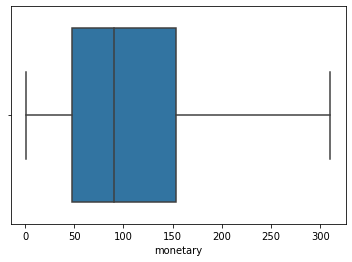

In [97]:
sns.boxplot(data=RFM_table, x='monetary',showfliers=False) # уберем выбросы с графика

In [98]:
# Определим следующие кластеры для monetary
klaster_M = [0, 47.9, 152.9, RFM_table.monetary.max()]
#     1 - до 25 процентиля
#     2 -  от 25 до 75 процентиля
#     3 - больше 75 процентиля
klaster_M

[0, 47.9, 152.9, 13440.0]

In [99]:
# Определим следующие кластеры для monetary
# Просто период в 1 год разделим поровну на три части, но в обратном порядке
klaster_R = [RFM_table.recency.max(), 242, 121, 0]
klaster_R

[364, 242, 121, 0]

In [100]:
# Напишем функции для присвоения рангов по каждому занчению в таблице
def r_score(x):
    if x >= klaster_R[1]:
        return 1
    elif x >= klaster_R[2]:
        return 2
    else:
        return 3
    
def f_score(x): 
    if x <= klaster_F[1]:
        return 1
    elif x <= klaster_F[2]:
        return 2
    else:
        return 3 

def m_score(x):
    if x <= klaster_M[1]:
        return 1
    elif x <= klaster_M[2]:
        return 2
    else:
        return 3 

In [101]:
# создаем столбцы и присваиваем ранги по значениям в соответсвующих колонках
RFM_table['R'] = RFM_table['recency'].apply(lambda x: r_score(x))
RFM_table['F'] = RFM_table['frequency'].apply(lambda x: f_score(x))
RFM_table['M'] = RFM_table['monetary'].apply(lambda x: m_score(x))
RFM_table.head()

,customer_unique_id,frequency,monetary,recency,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,119,3,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,326,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,293,1,1,3
4,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,151,2,1,3


In [102]:
RFM_table['RFM_Score'] = RFM_table['R'].map(str) + RFM_table['F'].map(str) + RFM_table['M'].map(str) 
#объединяем RFM в один столбец
RFM_table.head()

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,119,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,326,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,293,1,1,3,113
4,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,151,2,1,3,213


In [103]:
klaster_R, klaster_F, klaster_M 

([364, 242, 121, 0], [0, 1, 2, 11], [0, 47.9, 152.9, 13440.0])

In [104]:
# Напишем функции для описания каждого сегмента

def r_desc(x):
    if x >= klaster_R[1]:
        y = ' recency от ' + str(klaster_R[1]) + ' до ' + str(klaster_R[0]) + ' дней,'
        return y
    elif x >= klaster_R[2]:
        y = ' recency от ' + str(klaster_R[2]) + ' до ' + str(klaster_R[1]) + ' дней,'
        return y
    else:
        y = ' recency от ' + str(klaster_R[3]) + ' до ' + str(klaster_R[2]) + ' дней,'
        return y
    
def f_desc(x):
    if x <= klaster_F[1]:
        y = ' frequency ' + str(klaster_F[1]) + ' заказ,'
        return y
    elif x <= klaster_F[2]:
        y = ' frequency ' + str(klaster_F[2])  + ' заказа,'
        return y
    else:
        y = ' frequency от ' + str(klaster_F[2]+1) + ' до ' + str(klaster_F[3]) + ' заказов,'
        return y
    
def m_desc(x): 
    if x <= klaster_M[1]:
        y = ' monetary от ' + str(klaster_M[0]) + ' до ' + str(klaster_M[1]) + ' рублей.'
        return y
    elif x <= klaster_M[2]:
        y = ' monetary от ' + str(klaster_M[1]) + ' до ' + str(klaster_M[2]) + ' рублей.'
        return y
    else:
        y = ' monetary от ' + str(klaster_M[2]) + ' до ' + str(klaster_M[3]) + ' рублей.'
        return y 

In [105]:
# сделаем столбец с описанием сегмент
RFM_table['RFM_description'] = 'Границы метрик данного сегмента: ' + \
                    RFM_table['recency'].apply(r_desc) + \
                    RFM_table['frequency'].apply(f_desc) + \
                    RFM_table['monetary'].apply(m_desc)
pd.set_option('display.max_colwidth', None) # установим максимальную ширину столбца, чтобы описание полностью было видно
RFM_table.head()

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM_Score,RFM_description
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117,3,1,2,312,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей."
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,119,3,1,1,311,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 1 заказ, monetary от 0 до 47.9 рублей."
2,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,326,1,1,1,111,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 0 до 47.9 рублей."
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,293,1,1,3,113,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей."
4,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,151,2,1,3,213,"Границы метрик данного сегмента: recency от 121 до 242 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей."


In [106]:
# Всего у нас получается 3**3 = 27 комбинаций сегментов
# Определим из них несколько основых групп и сгруппируем их в словарь
segt_map = {
    r'11[1-3]': 'потерянные клиенты', # покупали давно, один раз
    r'1[2-3][1-3]': 'потеряли активность', # покупали давно, но несколько раз
    r'21[1-3]': 'спящие клиенты', # покупали относительно недавно, но один раз
    r'2[2-3][1-3]': 'лояльные, но спящие клиенты', # покупали относительно недавно, но несколько раз 
    r'31[1-3]': 'новые клиенты', # покупали недавно, но один раз
    r'3[2-3][1-2]': 'требуют внимания, разивающиеся клиенты', # покупали недавно, несколько раз, но мало тратили
    r'3[2-3]3': 'лидеры, постоянные клиенты' # покупали недавно, несколько раз и тратили деньги  
}

In [107]:
RFM_table['Segment'] = RFM_table['RFM_Score'] # подублируем столбец со значениями RFM
RFM_table['Segment'] = RFM_table['Segment'].replace(segt_map, regex=True) # заменим на описания сегмента, в который попал пользователь
RFM_table

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM_Score,RFM_description,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,117,3,1,2,312,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей.",новые клиенты
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,119,3,1,1,311,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 1 заказ, monetary от 0 до 47.9 рублей.",новые клиенты
2,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,326,1,1,1,111,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 0 до 47.9 рублей.",потерянные клиенты
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,293,1,1,3,113,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей.",потерянные клиенты
4,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,151,2,1,3,213,"Границы метрик данного сегмента: recency от 121 до 242 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей.",спящие клиенты
...,...,...,...,...,...,...,...,...,...,...
73263,fffb09418989a0dbff854a28163e47c6,1,58.00,259,1,1,2,112,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей.",потерянные клиенты
73264,fffbf87b7a1a6fa8b03f081c5f51a201,1,149.00,250,1,1,2,112,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей.",потерянные клиенты
73265,fffcc512b7dfecaffd80f13614af1d16,1,688.00,146,2,1,3,213,"Границы метрик данного сегмента: recency от 121 до 242 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей.",спящие клиенты
73266,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,267,1,1,2,112,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей.",потерянные клиенты


In [108]:
# сгруппируем по получившимся сегментам и посчитаем количество пользователей в сегментах
RFM_segment = RFM_table.groupby(['Segment'],  as_index=False)\
                       .agg({'customer_unique_id':'count', 'RFM_description':'first'})\
                       .rename(columns={'customer_unique_id':'Сount'})
RFM_segment 

,Segment,Сount,RFM_description
0,"лидеры, постоянные клиенты",308,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 2 заказа, monetary от 152.9 до 13440.0 рублей."
1,"лояльные, но спящие клиенты",753,"Границы метрик данного сегмента: recency от 121 до 242 дней, frequency 2 заказа, monetary от 47.9 до 152.9 рублей."
2,новые клиенты,23398,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 1 заказ, monetary от 47.9 до 152.9 рублей."
3,потеряли активность,590,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 2 заказа, monetary от 152.9 до 13440.0 рублей."
4,потерянные клиенты,21072,"Границы метрик данного сегмента: recency от 242 до 364 дней, frequency 1 заказ, monetary от 0 до 47.9 рублей."
5,спящие клиенты,26952,"Границы метрик данного сегмента: recency от 121 до 242 дней, frequency 1 заказ, monetary от 152.9 до 13440.0 рублей."
6,"требуют внимания, разивающиеся клиенты",195,"Границы метрик данного сегмента: recency от 0 до 121 дней, frequency 2 заказа, monetary от 47.9 до 152.9 рублей."


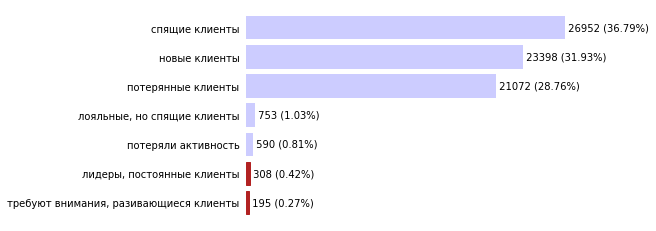

In [109]:
# построим график с кол-вом пользователей в каждом получившемся сегменте
segments_counts = RFM_table['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='blue',
              alpha = 0.2)
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['лидеры, постоянные клиенты', 'требуют внимания, разивающиеся клиенты']:
            bar.set_color('firebrick')
            bar.set_alpha(1)
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                ' {:} ({:}%)'.format(int(value),
                                   (value*100/segments_counts.sum()).round(2)),
                va='center',
                ha='left'
               )

plt.show()

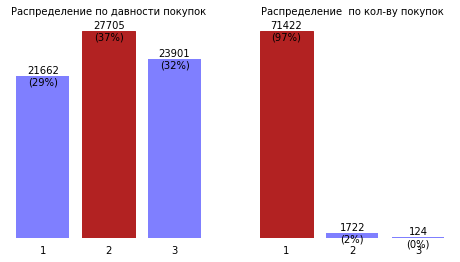

In [110]:
# график распределения пользователей по сегментам R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
for i, p in enumerate(['R', 'F']):
    parameters = {'R':'по давности покупок', 'F':' по кол-ву покупок'}
    y = RFM_table[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='blue', alpha = 0.5)
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение {}'.format(parameters[p]),
                fontsize=10)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
            bar.set_alpha(1)
        ax.text(bar.get_x() + bar.get_width() / 2,
                 value -3, 
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='center',
              
               color='black')

plt.show()


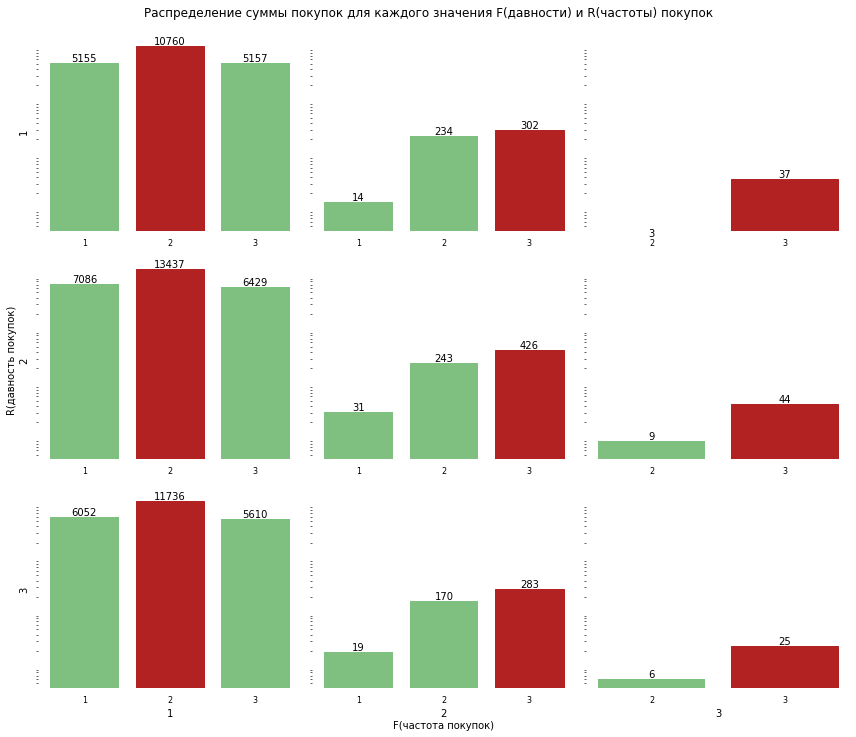

In [111]:

# график распределения суммы покупок для  RF score

fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(12, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = RFM_table[(RFM_table['R'] == r) & (RFM_table['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='green', alpha=0.5)
        # ставим подписи, чтобы получилось посередине всех графиков
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nF(частота покупок)'.format(f), va='top') 
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R(давность покупок)\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
                bar.set_alpha(1)
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение суммы покупок для каждого значения F(давности) и R(частоты) покупок',
             fontsize=12, y=1.02)
plt.yscale('log')
plt.tight_layout()
plt.show()